In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject


# Recommendation Systems 

Content Based Recommendation - Not relating other user's information to predict the new/similar customer but instead recommend similar items based on their choice (Ex. for Movie Recommendation, it will be Similar Genre). In current case of work, we will recommend items that are in close proximity with the customer's preferred vehicle specifications
<br>
Ex. Customer Input: 
* Range: 400
* Price: 50,000
* 0-100: 5
<br>
Based on the information provided, we will look at the cluster and pick the similar items with the input (KNN algorithm applied to extract the items in close proximity)

In [4]:
# Dataframe from Customer Segmentation
test = pd.read_csv('test.csv')
test.drop(columns='Unnamed: 0',inplace=True)
test = StandardScaler().fit_transform(test)
test = pd.DataFrame(test,columns=['range','price'])

In [7]:
test.head()

,range,price
0,-0.164652,1.357910
1,-0.164652,1.357910
2,-0.164652,0.173588
3,-0.164652,-1.010733
4,1.057238,-1.010733


In [6]:
# Dataframe from Vehicle Specification Clustering
dl = pd.read_csv('kmpca.csv')
dl.drop(columns='Unnamed: 0', inplace = True)

test2 = dl[['Range','Price(German)']]
test2 = StandardScaler().fit_transform(test2)
test2 = pd.DataFrame(test2, columns=['range','price'])
test2['cl'] = dl['Cluster']

In [8]:
test2.head()

,range,price,cl
0,-0.996290,-0.916877,Third
1,0.413697,3.656547,First
2,-1.466285,-0.514955,Second
3,-0.141753,-0.695732,Third
4,-0.910836,-0.653317,Third


In [23]:
dl.head()

,Battery,0 - 100,Top Speed,Range,Efficiency,Fastcharge,Price(German),PC1,PC2,Cluster,Model
0,37.0,7.9,144,225,164,230.0,29990.0,-1.994293,-1.317613,Third,Leaf
1,83.7,2.8,260,390,215,860.0,186336.0,3.887675,1.526946,First,Taycan Turbo S
2,37.0,14.0,123,170,218,170.0,43730.0,-3.313765,0.714488,Second,e-NV200 Evalia
3,56.0,7.3,157,325,172,390.0,37550.0,-0.746728,-0.981634,Third,Leaf e+
4,37.9,7.3,150,235,161,270.0,39000.0,-1.631201,-1.351793,Third,i3 120 Ah


In [24]:
def conditioned_nn(ev_cluster,customer_seg, n):
    
    # Running Nearest Neighbour
    neigh = NearestNeighbors(n_neighbors=n)
    neigh.fit(ev_cluster.iloc[:,:-1])
    nn_pred, nn_index = neigh.kneighbors(customer_seg)
    
    distance = pd.DataFrame(nn_pred) #Euclidean Distance for each neighbors
    index = pd.DataFrame(nn_index) #Index for the neighbor (labeling purpose)
    
    #Detecting outliers in terms of Euclidean Distance (NN brings neighbors that are too far away due to the given n_neighors)
    q75, q25 = np.percentile(distance[distance.columns[0]].values,[75,25]) #First Neighbor is always the closest, chosen as standard
    iqr = q75 - q25
    maximum = q75 + 1.5*iqr #Maximum value for distance 
    
    #Conditioning
    for i in range(len(distance)):
        for j in range(len(distance.iloc[i])):
            if distance.iloc[i,j] > maximum: #Condition to Satisfy, if the distance is greater than this value, do not consider
                distance.iloc[i,j] = np.nan
                index.iloc[i,j] = 0 #Replace the conditioned value to 0 (We are going to keep the dataframe structure)
    
    #Because the values from customer segments are Scaled, there are many duplicate values
    selected = customer_seg[~customer_seg.duplicated()].reset_index() # Removing Duplicate
    cond_index = index.reset_index() #Index for Each Sample
    
    #Combine the two dataframe - Removed Duplicate + Index for neighbor datapoints
    labeled = pd.merge(selected, cond_index, on=['index'])
    
    #For recommendation system purpose, Create tuples, that contains the (Neighbor Index, Sample Number)
    indexing = []
    for i in range(len(labeled)):
        for j in labeled.iloc[i,3:]:
            if j != 0:
                indexing.append((int(j),i))
    
    #Graphing the Clusters Together
    sns.scatterplot(x=ev_cluster['range'],y=ev_cluster['price'], color='red')
    sns.scatterplot(ev_cluster['range'].iloc[[i[0] for i in indexing]], ev_cluster['price'].iloc[[i[0] for i in indexing]], color='black')
    sns.scatterplot(customer_seg['range'], customer_seg['price'], color ='pink')
    
    #Extract out the Actual Model that are in close proximity as the Customer data point
    for i in indexing:
        print('Recommended Vehicle:{}  customer:{}  Vehicle Group:{}'.format(dl['Model'].iloc[i[0]],i[1],dl['Cluster'].iloc[i[0]]))
        
    return 

Recommended Vehicle:e-tron S Sportback 55 quattro  customer:0  Vehicle Group:Fourth
Recommended Vehicle:e-tron S 55 quattro  customer:0  Vehicle Group:Fourth
Recommended Vehicle:Taycan 4S  customer:0  Vehicle Group:First
Recommended Vehicle:EQV 300 Long  customer:1  Vehicle Group:Second
Recommended Vehicle:EQV 300 Extra-Long  customer:1  Vehicle Group:Second
Recommended Vehicle:C40 Recharge  customer:1  Vehicle Group:Fourth
Recommended Vehicle:e-tron Sportback 50 quattro  customer:1  Vehicle Group:Fourth
Recommended Vehicle:XC40 Recharge Twin Pure Electric  customer:1  Vehicle Group:Fourth
Recommended Vehicle:Zoe ZE50 R110  customer:2  Vehicle Group:Third
Recommended Vehicle:MG5 Electric  customer:2  Vehicle Group:Third
Recommended Vehicle:Zoe ZE50 R135  customer:2  Vehicle Group:Third
Recommended Vehicle:U5   customer:2  Vehicle Group:Third
Recommended Vehicle:Enyaq iV 50  customer:2  Vehicle Group:Third
Recommended Vehicle:ID.3 Pro S - 4 Seats  customer:3  Vehicle Group:Fourth
Recomm

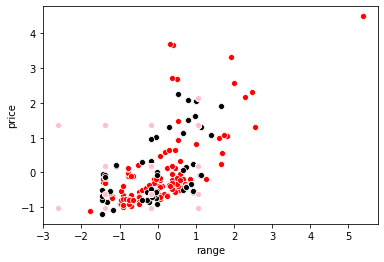

In [25]:
cd = conditioned_nn(test2,test,5)